<img src=https://i.imgur.com/WKQ0nH2.jpg height=350>

# Setup and Context


### Introduction

Welcome to Boston Massachusetts in the 1970s! Imagine we're working for a real estate development company. My boss wants to know how much a completed residential project will be worth before committing. We are tasked with building a model that can provide a price estimate based on a home's characteristics like:
* The number of rooms
* The distance to employment centres
* How rich or poor the area is
* How many students there are per teacher in local schools etc

To accomplish the task we will:

1. Analyse and explore the Boston house price data
2. Split the data for training and testing
3. Run a Multivariable Regression
4. Evaluate the model's coefficients and residuals
5. Use data transformation to improve model performance
6. Use the model to estimate a property price

###  Import Statements


In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# TODO: Add missing import statements

### Notebook Presentation

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

# Load the Data

The first column in the .csv file just has the row numbers, so it will be used as the index. 

In [3]:
data = pd.read_csv('boston.csv', index_col=0)

### Understand the Boston House Price Dataset

---------------------------

**Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. The Median Value (attribute 14) is the target.

    :Attribute Information (in order):
        1. CRIM     per capita crime rate by town
        2. ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        3. INDUS    proportion of non-retail business acres per town
        4. CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        5. NOX      nitric oxides concentration (parts per 10 million)
        6. RM       average number of rooms per dwelling
        7. AGE      proportion of owner-occupied units built prior to 1940
        8. DIS      weighted distances to five Boston employment centres
        9. RAD      index of accessibility to radial highways
        10. TAX      full-value property-tax rate per $10,000
        11. PTRATIO  pupil-teacher ratio by town
        12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        13. LSTAT    % lower status of the population
        14. PRICE     Median value of owner-occupied homes in $1000's
        
    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of [UCI ML housing dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/). This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University. You can find the [original research paper here](https://deepblue.lib.umich.edu/bitstream/handle/2027.42/22636/0000186.pdf?sequence=1&isAllowed=y). 


# Preliminary Data Exploration 🔎

**Questions to be answered:**

* What is the shape of `data`? 
* How many rows and columns does it have?
* What are the column names?
* Are there any NaN values or duplicates?

In [4]:
print(f"The data has {data.shape[0]} rows and {data.shape[1]} columns.")

The data has 506 rows and 14 columns.


In [5]:
data.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'PRICE'],
      dtype='object')

### Data Cleaning - Check for Missing Values and Duplicates

In [6]:
data.isna().values.any()

False

In [7]:
data.duplicated().values.any()

False

## Descriptive Statistics

**Questions to be answered**

* How many students are there per teacher on average?
* What is the average price of a home in the dataset?
* What is the `CHAS` feature? 
* What are the minimum and the maximum value of the `CHAS` and why?
* What is the maximum and the minimum number of rooms per dwelling in the dataset?

In [8]:
print(f"On average, there are {data.PTRATIO.mean():.2f} students per teacher.")

On average, there are 18.46 students per teacher.


In [9]:
print(f"The average price of a home in the dataset is ${data.PRICE.mean()*1000:,.0f}.")

The average price of a home in the dataset is $22,533.


In [10]:
print(f"CHAS is a boolean variable, with a minimum value of {data.CHAS.min()} and a maximum value of {data.CHAS.max()}.")

CHAS is a boolean variable, with a minimum value of 0.0 and a maximum value of 1.0.


## Visualise the Features

Using [Seaborn's `.displot()`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot), we will create a bar chart and superimpose the Kernel Density Estimate (KDE) for the following variables: 
* PRICE: The home price in thousands.
* RM: the average number of rooms per owner unit.
* DIS: the weighted distance to the 5 Boston employment centres i.e., the estimated length of the commute.
* RAD: the index of accessibility to highways. 

#### House Prices 💰

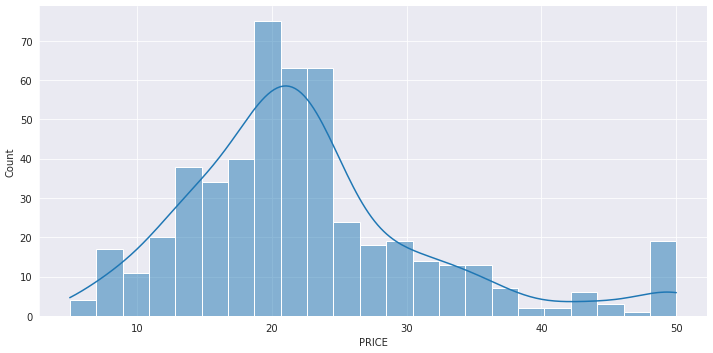

In [11]:
with sns.axes_style('darkgrid'):
    price_dist = sns.displot(data,
                            x='PRICE',
                            kde=True,
                            aspect=2)

plt.show()

#### Distance to Employment - Length of Commute 🚗

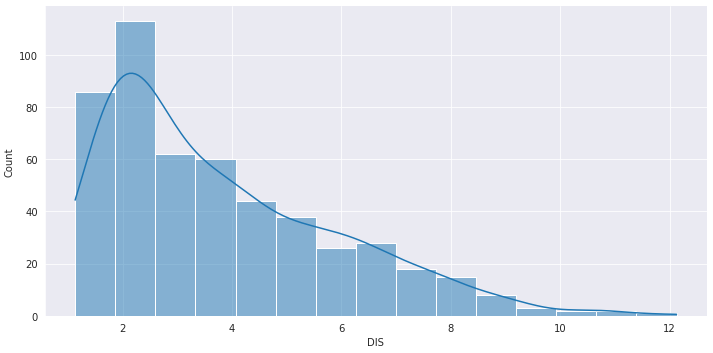

In [12]:
with sns.axes_style('darkgrid'):
    price_dist = sns.displot(data,
                            x='DIS',
                            kde=True,
                            aspect=2)

plt.show()

#### Number of Rooms

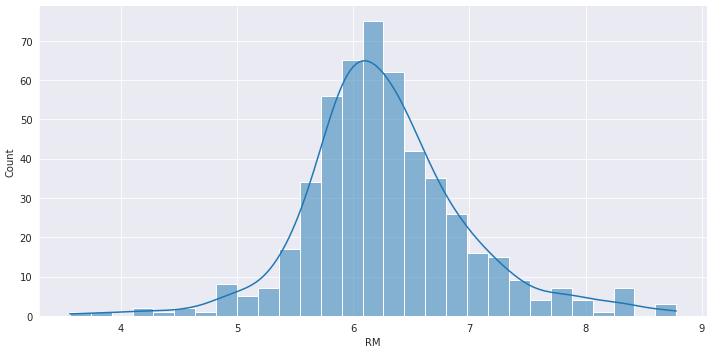

In [13]:
with sns.axes_style('darkgrid'):
    price_dist = sns.displot(data,
                            x='RM',
                            kde=True,
                            aspect=2)

plt.show()

#### Access to Highways 🛣

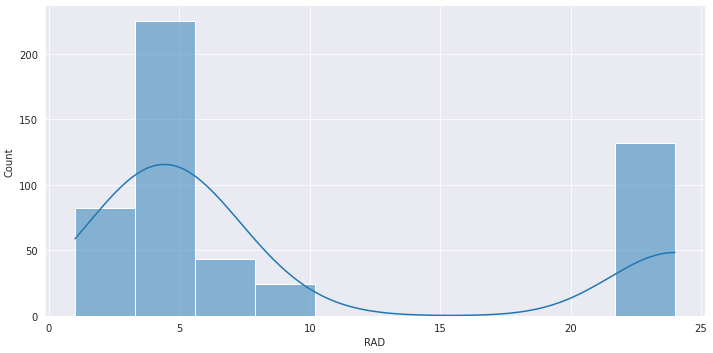

In [14]:
with sns.axes_style('darkgrid'):
    price_dist = sns.displot(data,
                            x='RAD',
                            kde=True,
                            aspect=2)

plt.show()

#### Next to the River? ⛵️

Are there many houses that are close to a the River?

In [15]:
river_counts = data.CHAS.value_counts()

river_counts = river_counts.rename(index={0.00:'No', 1.00:'Yes'})

In [16]:
river_bar = px.bar(river_counts,
                   x=river_counts.index,
                  y=river_counts.values,
                  color=river_counts.index,
                  hover_name=river_counts.index)

river_bar.update_layout(xaxis_title='Property Located Next to the River?', yaxis_title='Number of Homes')
river_bar.show()

# Understanding the Relationships between Attributes

### Run a Pair Plot

There might be some relationships in the data that we should know about, such as:

* the relationship to be between pollution (NOX) and the distance to employment (DIS)? 
* the relationship do you expect between the number of rooms (RM) and the home value (PRICE)?
* the relationship between the amount of poverty in an area (LSTAT) and home prices? 

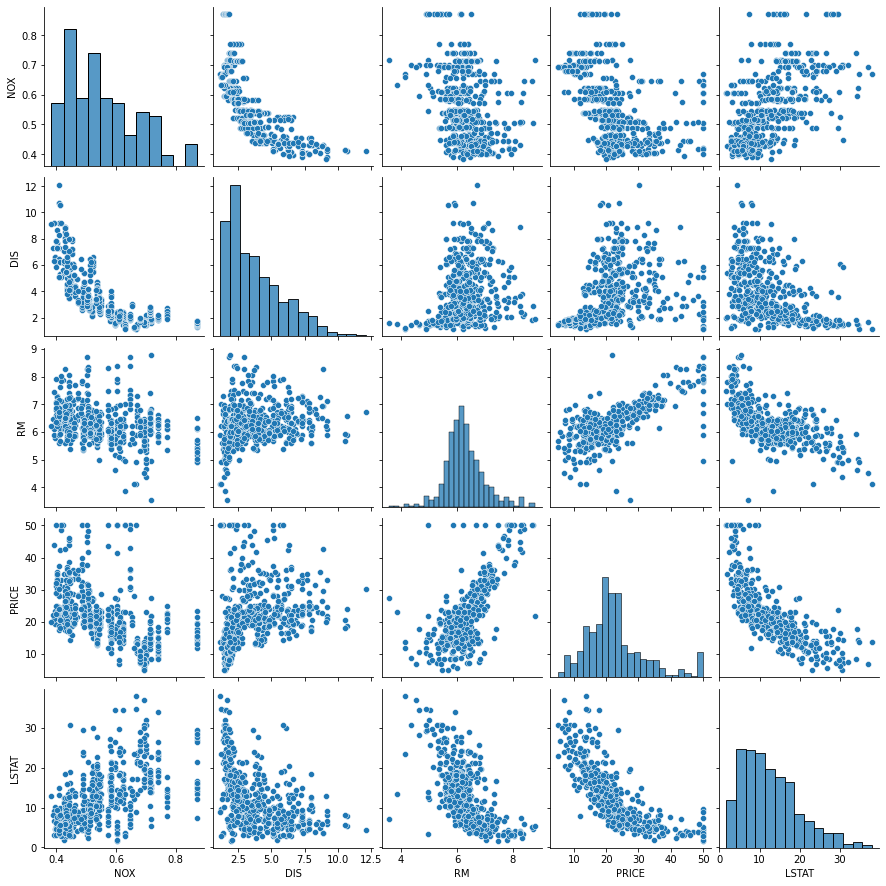

In [17]:
sns.pairplot(data, vars=['NOX', 'DIS', 'RM','PRICE','LSTAT'])

plt.show()

Let's use [Seaborn's `.jointplot()`](https://seaborn.pydata.org/generated/seaborn.jointplot.html) to look at the following pairs in more detail:

* DIS and NOX
* LSTAT vs RM
* LSTAT vs PRICE
* RM vs PRICE


#### Distance from Employment vs. Pollution

Does pollution go up or down as the distance increases? 

<Figure size 1600x800 with 0 Axes>

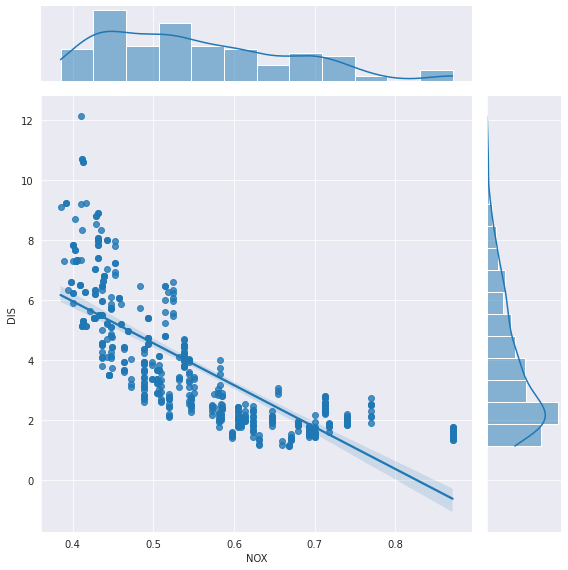

In [18]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style('darkgrid'):
    sns.jointplot(data=data, 
                  x='NOX',
                  y='DIS',
                  height=8,
                  kind='reg')
    
plt.show()

#### % of Lower Income Population vs Average Number of Rooms

How does the number of rooms per dwelling vary with the poverty of area? Do homes have more or fewer rooms when LSTAT is low?

<Figure size 3200x1600 with 0 Axes>

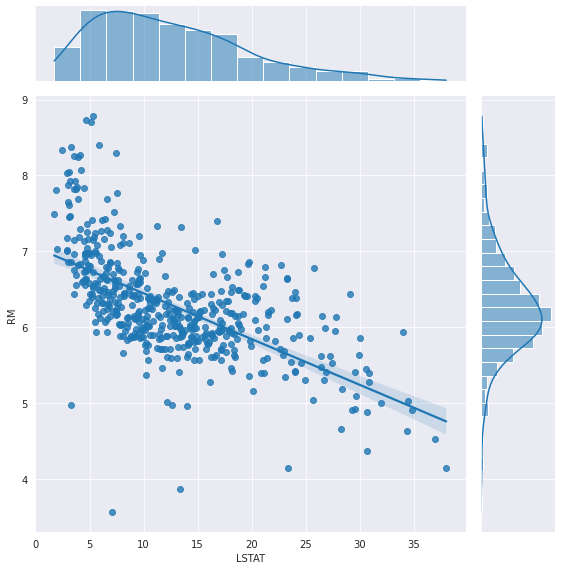

In [19]:
plt.figure(figsize=(16,8), dpi=200)
with sns.axes_style('darkgrid'):
    sns.jointplot(data=data, 
                  x='LSTAT',
                  y='RM',
                  height=8,
                  kind='reg')
    
plt.show()

#### % of Lower Income Population versus Home Price

How does the proportion of the lower-income population in an area affect home prices?

<Figure size 1600x800 with 0 Axes>

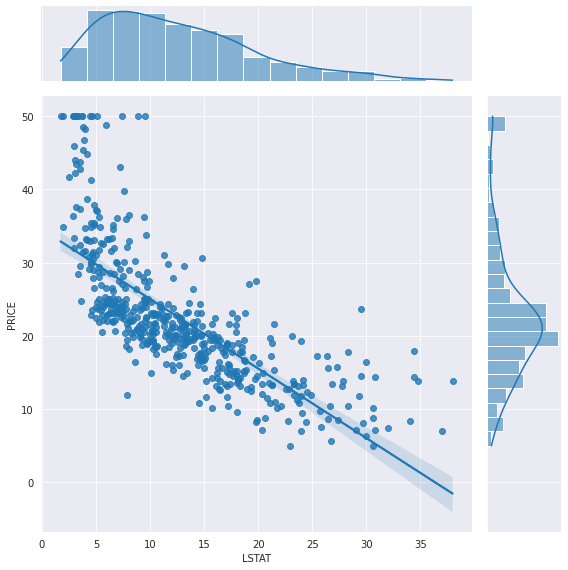

In [20]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style('darkgrid'):
    sns.jointplot(data=data, 
                  x='LSTAT',
                  y='PRICE',
                  height=8,
                  kind='reg')
    
plt.show()

#### Number of Rooms versus Home Value

How does the number of rooms affect home prices? Well, it should not come as a surprise.

<Figure size 1600x800 with 0 Axes>

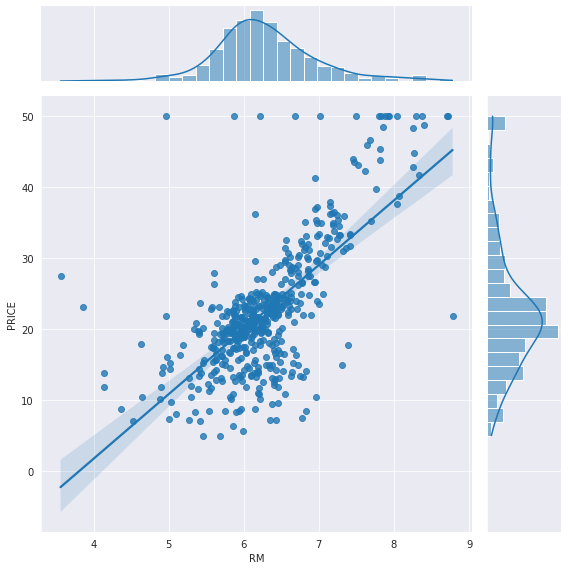

In [21]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style('darkgrid'):
    sns.jointplot(data=data, 
                  x='RM',
                  y='PRICE',
                  height=8,
                  kind='reg')
    
plt.show()

# Split Training & Test Dataset

To get a better idea of the model's performance in the real world, we can't use all 506 entries in our dataset to train our model. We need to keep a slice of the data to use as out-of-sample data.

**Tasks**

* Import the [`train_test_split()` function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from sklearn
* Create 4 subsets: X_train, X_test, y_train, y_test
* Split the training and testing data roughly 80/20. 


In [64]:
X=data.drop(columns=['PRICE'])
y=data.PRICE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Multivariable Regression

With a total of 13 features, our Linear Regression model will have the following form:

$$ PR \hat ICE = \theta _0 + \theta _1 RM + \theta _2 NOX + \theta _3 DIS + \theta _4 CHAS ... + \theta _{13} LSTAT$$

### Run the Regression

How high is the r-squared for the regression on the training data?

In [65]:
reg = LinearRegression()

In [66]:
reg.fit(X_train, y_train)

LinearRegression()

In [67]:
print(f"Intercept: {reg.intercept_}")
print(f"Coefficient: {reg.coef_}")
print(f"R-squared: {reg.score(X_train, y_train):.4f}")

Intercept: 36.53305138282446
Coefficient: [-1.28180656e-01  6.31981786e-02 -7.57627602e-03  1.97451452e+00
 -1.62719890e+01  3.10845625e+00  1.62922153e-02 -1.48301360e+00
  3.03988206e-01 -1.20820710e-02 -8.20305699e-01  1.14189890e-02
 -5.81626431e-01]
R-squared: 0.7501


### Evaluate the Coefficients of the Model

Based on our domain knowledge, do the coefficients have the expected sign (positive or negative)?

In [68]:
index_list = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']

In [69]:
print(f"Coefficient: {reg.coef_}")

Coefficient: [-1.28180656e-01  6.31981786e-02 -7.57627602e-03  1.97451452e+00
 -1.62719890e+01  3.10845625e+00  1.62922153e-02 -1.48301360e+00
  3.03988206e-01 -1.20820710e-02 -8.20305699e-01  1.14189890e-02
 -5.81626431e-01]


In [70]:
coef = pd.DataFrame(reg.coef_, index=index_list)
coef

0
CRIM     -0.13
ZN        0.06
INDUS    -0.01
CHAS      1.97
NOX     -16.27
RM        3.11
AGE       0.02
DIS      -1.48
RAD       0.30
TAX      -0.01
PTRATIO  -0.82
B         0.01
LSTAT    -0.58

### Analyse the Estimated Values & Regression Residuals

The next step is to evaluate our regression. How good our regression is depends not only on the r-squared. It also depends on the **residuals** - the difference between the model's predictions ($\hat y_i$) and the true values ($y_i$) inside `y_train`. 

```
predicted_values = regr.predict(X_train)
residuals = (y_train - predicted_values)
```

We will be making 2 scatterplots. The first plot should be actual values (`y_train`) against the predicted value values, where the the distance to the best fit line (cyan) represents our residuals.


The second plot should be the residuals against the predicted prices. Ideally the residuals should have a mean of 0, and not too skewed (best not to have very large outliers in the positive or negative direction for our residuals).



In [76]:
predicted_values = reg.predict(X_train)

In [77]:
residuals = (y_train - predicted_values)

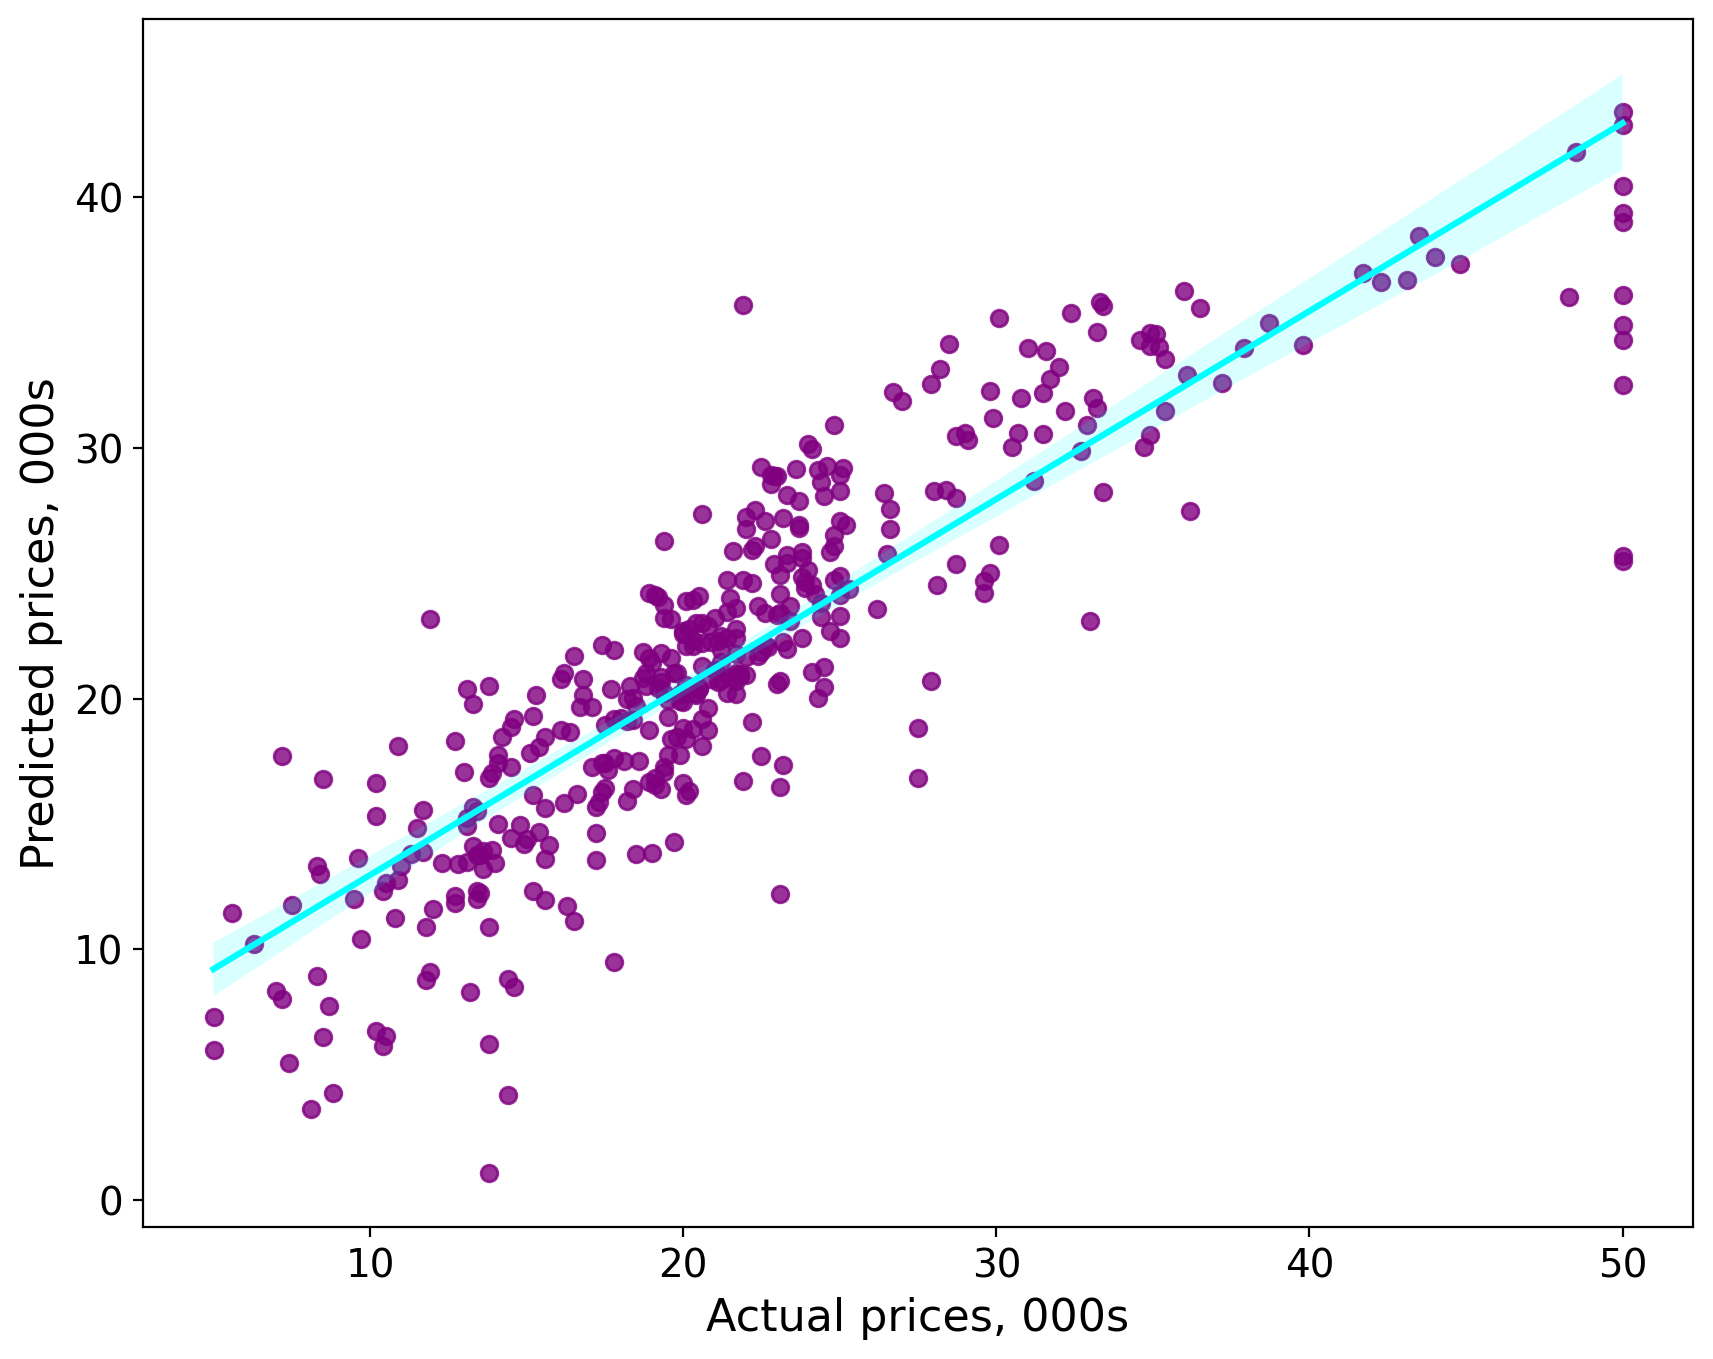

In [78]:
plt.figure(figsize=(10,8), dpi=200)


sns.regplot(x=y_train,
            y=predicted_values,
            color='purple',
            line_kws={'color':'cyan'})

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Actual prices, 000s', fontsize=16)
plt.ylabel('Predicted prices, 000s', fontsize=16)

plt.show()       

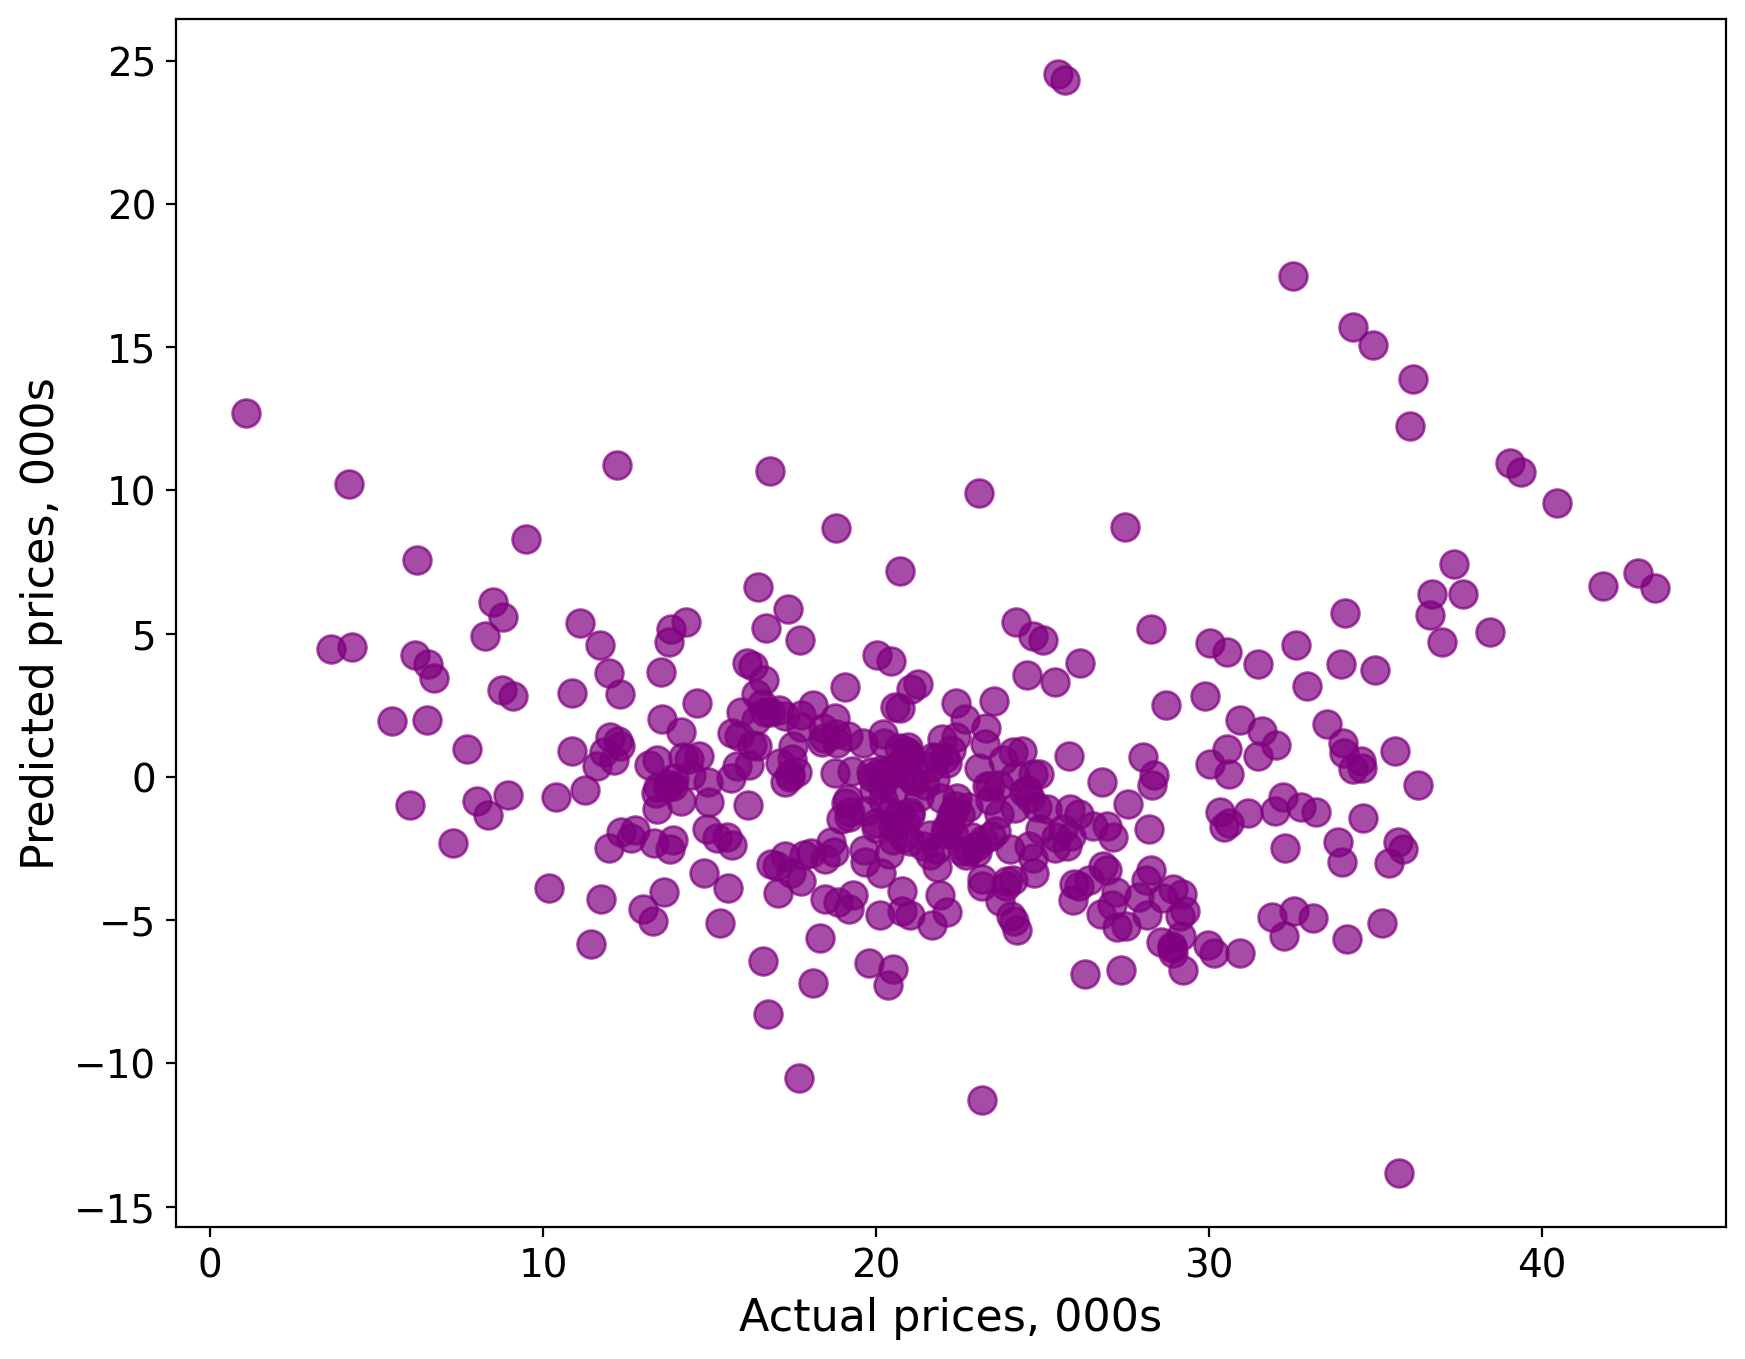

In [79]:
plt.figure(figsize=(10,8), dpi=200)


plt.plot(predicted_values,
         residuals,
         color='purple',
         marker='o',
         alpha=0.7,
         markersize=10,
        linewidth=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Actual prices, 000s', fontsize=16)
plt.ylabel('Predicted prices, 000s', fontsize=16)

plt.show()       

**Tasks**

* Calculate the mean and the skewness of the residuals. 
* Again, use Seaborn's `.displot()` to create a histogram and superimpose the Kernel Density Estimate (KDE)
* Is the skewness different from zero? If so, by how much? 
* Is the mean different from zero?

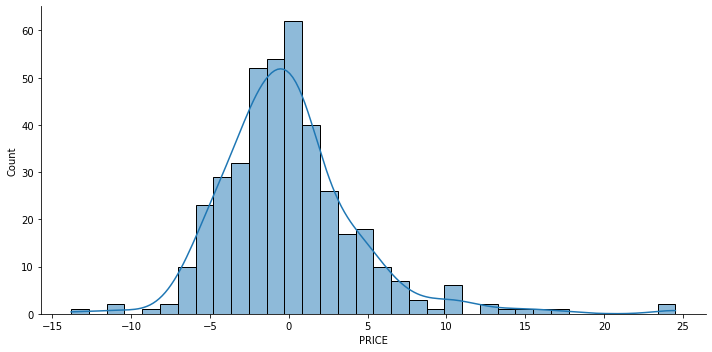

In [80]:
sns.displot(residuals, 
            kde=True,
            aspect=2)

In [81]:
resid_mean=residuals.mean()

In [82]:
resid_skew=residuals.skew()

In [83]:
print(f"The residuals have a mean of {resid_mean} and a skewness of {resid_skew}.")

The residuals have a mean of -1.3762368582482139e-15 and a skewness of 1.4594428196679827.


### Data Transformations for a Better Fit

We have two options at this point: 

1. Change our model entirely. Perhaps a linear model is not appropriate. 
2. Transform our data to make it fit better with our linear model. 

Let's try the data transformation approach on the target `data['PRICE']`. 

**Tasks**
* Use Seaborn's `.displot()` to show a histogram and KDE of the price data. 
* Calculate the skew of that distribution.
* Use [NumPy's `log()` function](https://numpy.org/doc/stable/reference/generated/numpy.log.html) to create a Series that has the log prices
* Plot the log prices using Seaborn's `.displot()` and calculate the skew. 
* Which distribution has a skew that's closer to zero? 

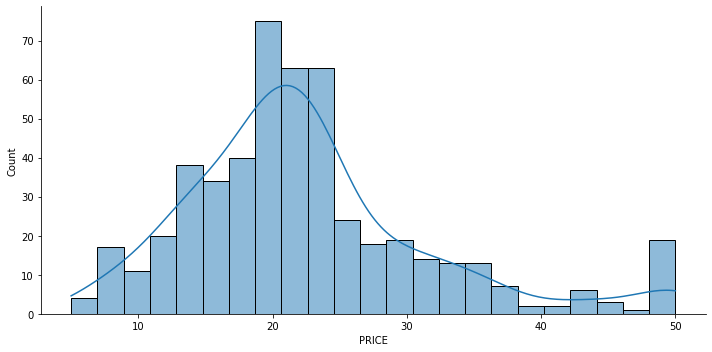

In [84]:
sns.displot(data.PRICE,
            kde=True,
            aspect=2)

In [85]:
data.PRICE.skew()

1.1080984082549072

In [86]:
log_price = np.log(data.PRICE)

-0.33032129530987864

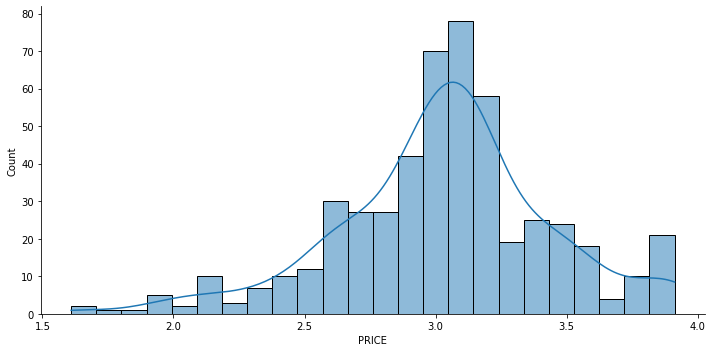

In [87]:
sns.displot(log_price,
            kde=True,
            aspect=2)

log_price.skew()

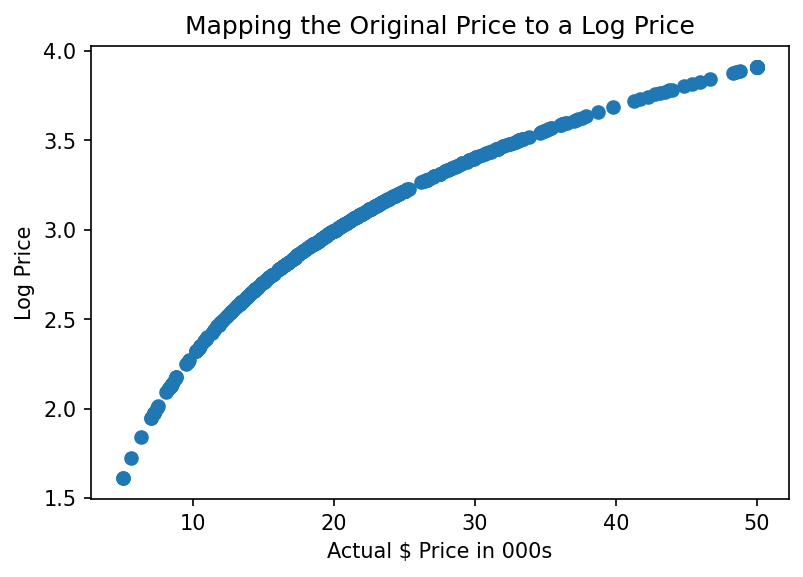

This is what Log does to our Target (Home Price).


In [88]:
plt.figure(dpi=150)
plt.scatter(data.PRICE, np.log(data.PRICE))

plt.title('Mapping the Original Price to a Log Price')
plt.ylabel('Log Price')
plt.xlabel('Actual $ Price in 000s')
plt.show()

print("This is what Log does to our Target (Home Price).")

## Regression using Log Prices

Using log prices instead, our model has changed to:

$$ \log (PR \hat ICE) = \theta _0 + \theta _1 RM + \theta _2 NOX + \theta_3 DIS + \theta _4 CHAS + ... + \theta _{13} LSTAT $$

**Tasks**: 

* Use `train_test_split()` with the same random state as before to make the results comparable. 
* Run a second regression, but this time use the transformed target data. 
* What is the r-squared of the regression on the training data? 
* Have we improved the fit of our model compared to before based on this measure?


In [44]:
reg2=LinearRegression()

In [89]:
X_train, X_test, logy_train, logy_test = train_test_split(X, log_price, test_size=0.2, random_state=10)

In [90]:
reg2.fit(X_train, logy_train)

LinearRegression()

In [91]:
predicted_log_values = reg2.predict(X_train)
residuals_log = (logy_train - predicted_log_values)

In [92]:
print(f"Intercept: {reg2.intercept_}")
print(f"Coefficient: {reg2.coef_}")
print(f"R-squared: {reg2.score(X_train, logy_train):.4f}")

Intercept: 4.059943871775202
Coefficient: [-1.06717261e-02  1.57929102e-03  2.02989827e-03  8.03305301e-02
 -7.04068057e-01  7.34044072e-02  7.63301755e-04 -4.76332789e-02
  1.45651350e-02 -6.44998303e-04 -3.47947628e-02  5.15896157e-04
 -3.13900565e-02]
R-squared: 0.7930


## Evaluating Coefficients with Log Prices

In [93]:
log_coef = pd.DataFrame(reg2.coef_, index=index_list)

In [94]:
log_coef.columns=(['coef'])

## Regression with Log Prices & Residual Plots

We are adding 2 more scatterplots so that we can compare the regression outcomes with the log prices side by side.

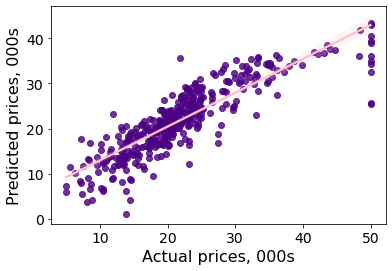

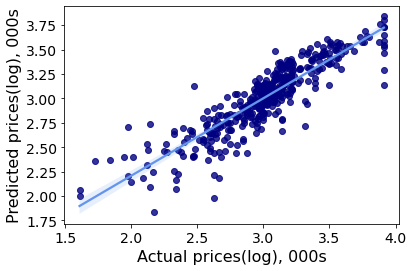

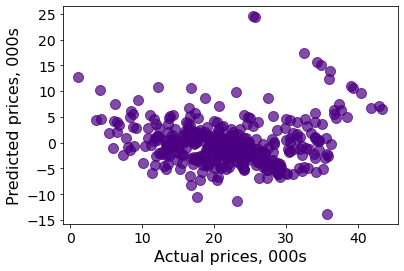

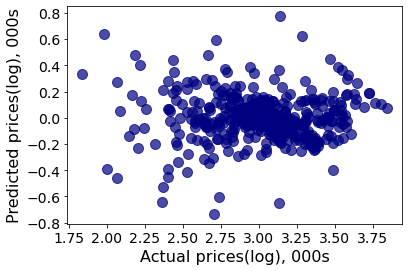

In [95]:
sns.regplot(x=y_train,
            y=predicted_values,
            color='indigo',
            line_kws={'color':'pink'})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Actual prices, 000s', fontsize=16)
plt.ylabel('Predicted prices, 000s', fontsize=16)
plt.show()

sns.regplot(x=logy_train,
            y=predicted_log_values,
            color='navy',
            line_kws={'color':'cornflowerblue'})

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Actual prices(log), 000s', fontsize=16)
plt.ylabel('Predicted prices(log), 000s', fontsize=16)
plt.show()

plt.plot(predicted_values,
         residuals,
         color='indigo',
         marker='o',
         alpha=0.7,
         markersize=10,
        linewidth=0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Actual prices, 000s', fontsize=16)
plt.ylabel('Predicted prices, 000s', fontsize=16)
plt.show()    

plt.plot(predicted_log_values,
         residuals_log,
         color='navy',
         marker='o',
         alpha=0.7,
         markersize=10,
        linewidth=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Actual prices(log), 000s', fontsize=16)
plt.ylabel('Predicted prices(log), 000s', fontsize=16)

plt.show()  

**Challenge**: 

Calculate the mean and the skew for the residuals using log prices. Are the mean and skew closer to 0 for the regression using log prices?

In [96]:
log_resid_mean = residuals_log.mean()

print(f"The mean of the residuals using log prices is: {log_resid_mean:.2f}.")

The mean of the residuals using log prices is: 0.00.


In [97]:
log_resid_skew = residuals_log.skew()

print(f"The skewness of the residuals using log prices is: {log_resid_skew:.2f}.")

The skewness of the residuals using log prices is: 0.09.


Text(0.5, 1.0, 'Log model: Residuals Skew (0.09), Residuals Mean (0.00)')

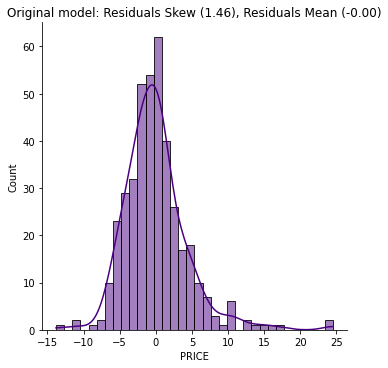

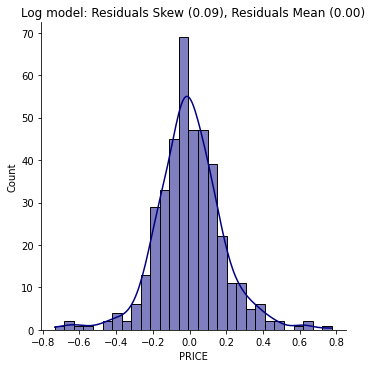

In [98]:
sns.displot(x=residuals, kde=True, color='indigo')
plt.title(f"Original model: Residuals Skew ({resid_skew:.2f}), Residuals Mean ({resid_mean:.2f})")

sns.displot(x=residuals_log, kde=True, color='navy')
plt.title(f"Log model: Residuals Skew ({log_resid_skew:.2f}), Residuals Mean ({log_resid_mean:.2f})")

# Compare Out of Sample Performance

The *real* test is how our model performs on data that it has not "seen" yet. This is where our `X_test` comes in. 

Compare the r-squared of the two models on the test dataset, R-squared of model 2 is higher, which means for the log model, a higher proportion of the variation in prices can be explained by the features adopted. The log model is a better fit for the regression.

In [101]:
print(f"R-squared of model 1: {reg.score(X_test, y_test)}")

R-squared of model 1: 0.6709339839115638


In [102]:
print(f"R-squared of model 2: {reg2.score(X_test, logy_test)}")

R-squared of model 2: 0.744692230626074


# Predict a Property's Value using the Regression Coefficients

Our preferred model now has an equation that looks like this:

$$ \log (PR \hat ICE) = \theta _0 + \theta _1 RM + \theta _2 NOX + \theta_3 DIS + \theta _4 CHAS + ... + \theta _{13} LSTAT $$

The average property has the mean value for all its charactistics:

In [103]:
# Starting Point: Average Values in the Dataset
features = data.drop(['PRICE'], axis=1)
average_vals = features.mean().values
property_stats = pd.DataFrame(data=average_vals.reshape(1, len(features.columns)), 
                              columns=features.columns)
property_stats

CRIM    ZN  INDUS  CHAS  NOX   RM   AGE  DIS  RAD    TAX  PTRATIO      B  \
0  3.61 11.36  11.14  0.07 0.55 6.28 68.57 3.80 9.55 408.24    18.46 356.67   

   LSTAT  
0  12.65

### Using the stats above, we will now predict how much the average property is worth. 

In [104]:
log_estimate = reg2.predict(property_stats)

dollar_estimate = np.exp(log_estimate)

In [105]:
print(f"The average property is worth ${dollar_estimate[0]*1000:,.0f}.")

The average property is worth $20,703.
